# Imports

In [1]:
import re
import unicodedata
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import textstat

from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm

from textblob import TextBlob
from textblob_nl import PatternAnalyzer

warnings.filterwarnings("ignore")

# set language to dutch 
textstat.set_lang("nl")

# progress bar when apply functions to dataframe
tqdm.pandas()

# better quality plots
%config InlineBackend.figure_format = "retina"

# Title font size
TITLE_SIZE = 14


# Data inladen 

Ik gebruik voor nu toch wel de dataset van 

In [2]:
#read dataset / update version 5 - feb 2025b 
df = pd.read_feather(r"C:\Users\dylan\Thesis\GIT\Datasets\NOS_NL_articles_2015_feb_2025.feather")

# Ensure 'published_time' column is in datetime format
df['published_time'] = pd.to_datetime(df['published_time'])

# Display last three rows
df.tail(4)

,channel,url,type,title,keywords,section,description,published_time,modified_time,image,content
1805,nos,https://nos.nl/l/2557705,article,"Schoof spreekt steun uit voor Oekraïne, kritie...","Schoof, Dick, nederland, trump, donald, Oekraïne",Politiek,Het Nederlandse kabinet laat weten achter Oekr...,2025-02-28 22:33:24,2025-02-28 22:33:24,https://cdn.nos.nl/image/2025/02/28/1197005/10...,"<h1>Schoof spreekt steun uit voor Oekraïne, kr..."
1806,nos,https://nos.nl/l/2557706,article,Flets Bayern doet precies genoeg en wint van S...,"Bayern München, Bundesliga, VfB Stuttgart",Voetbal,De Bundesliga-koploper speelt bepaald niet gro...,2025-02-28 22:54:12,2025-02-28 22:54:12,https://cdn.nos.nl/image/2025/02/28/1197008/10...,<h1>Flets Bayern doet precies genoeg en wint v...
1807,nos,https://nos.nl/l/2557709,article,Rodri hervat na ruim vijf maanden afwezigheid ...,"Manchester City, Rodri",Voetbal,De winnaar van de Ballon d'Or scheurde in sept...,2025-02-28 23:22:57,2025-02-28 23:22:57,https://cdn.nos.nl/image/2025/02/28/1197018/10...,<h1>Rodri hervat na ruim vijf maanden afwezigh...
1808,nos,https://nos.nl/l/2557710,article,"Ruzie is klap voor Oekraïne, 'Poetin zit te la...","Donald Trump, Nieuwsuur, Rusland, Oekraïne, Ve...",Buitenland,De ongekende aanvaring tussen Zelensky en Trum...,2025-02-28 23:34:07,2025-02-28 23:34:07,https://cdn.nos.nl/image/2025/02/28/1197020/10...,"<h1>Ruzie is klap voor Oekraïne, 'Poetin zit t..."


# Data bekijken 

### Totaal artikelen 

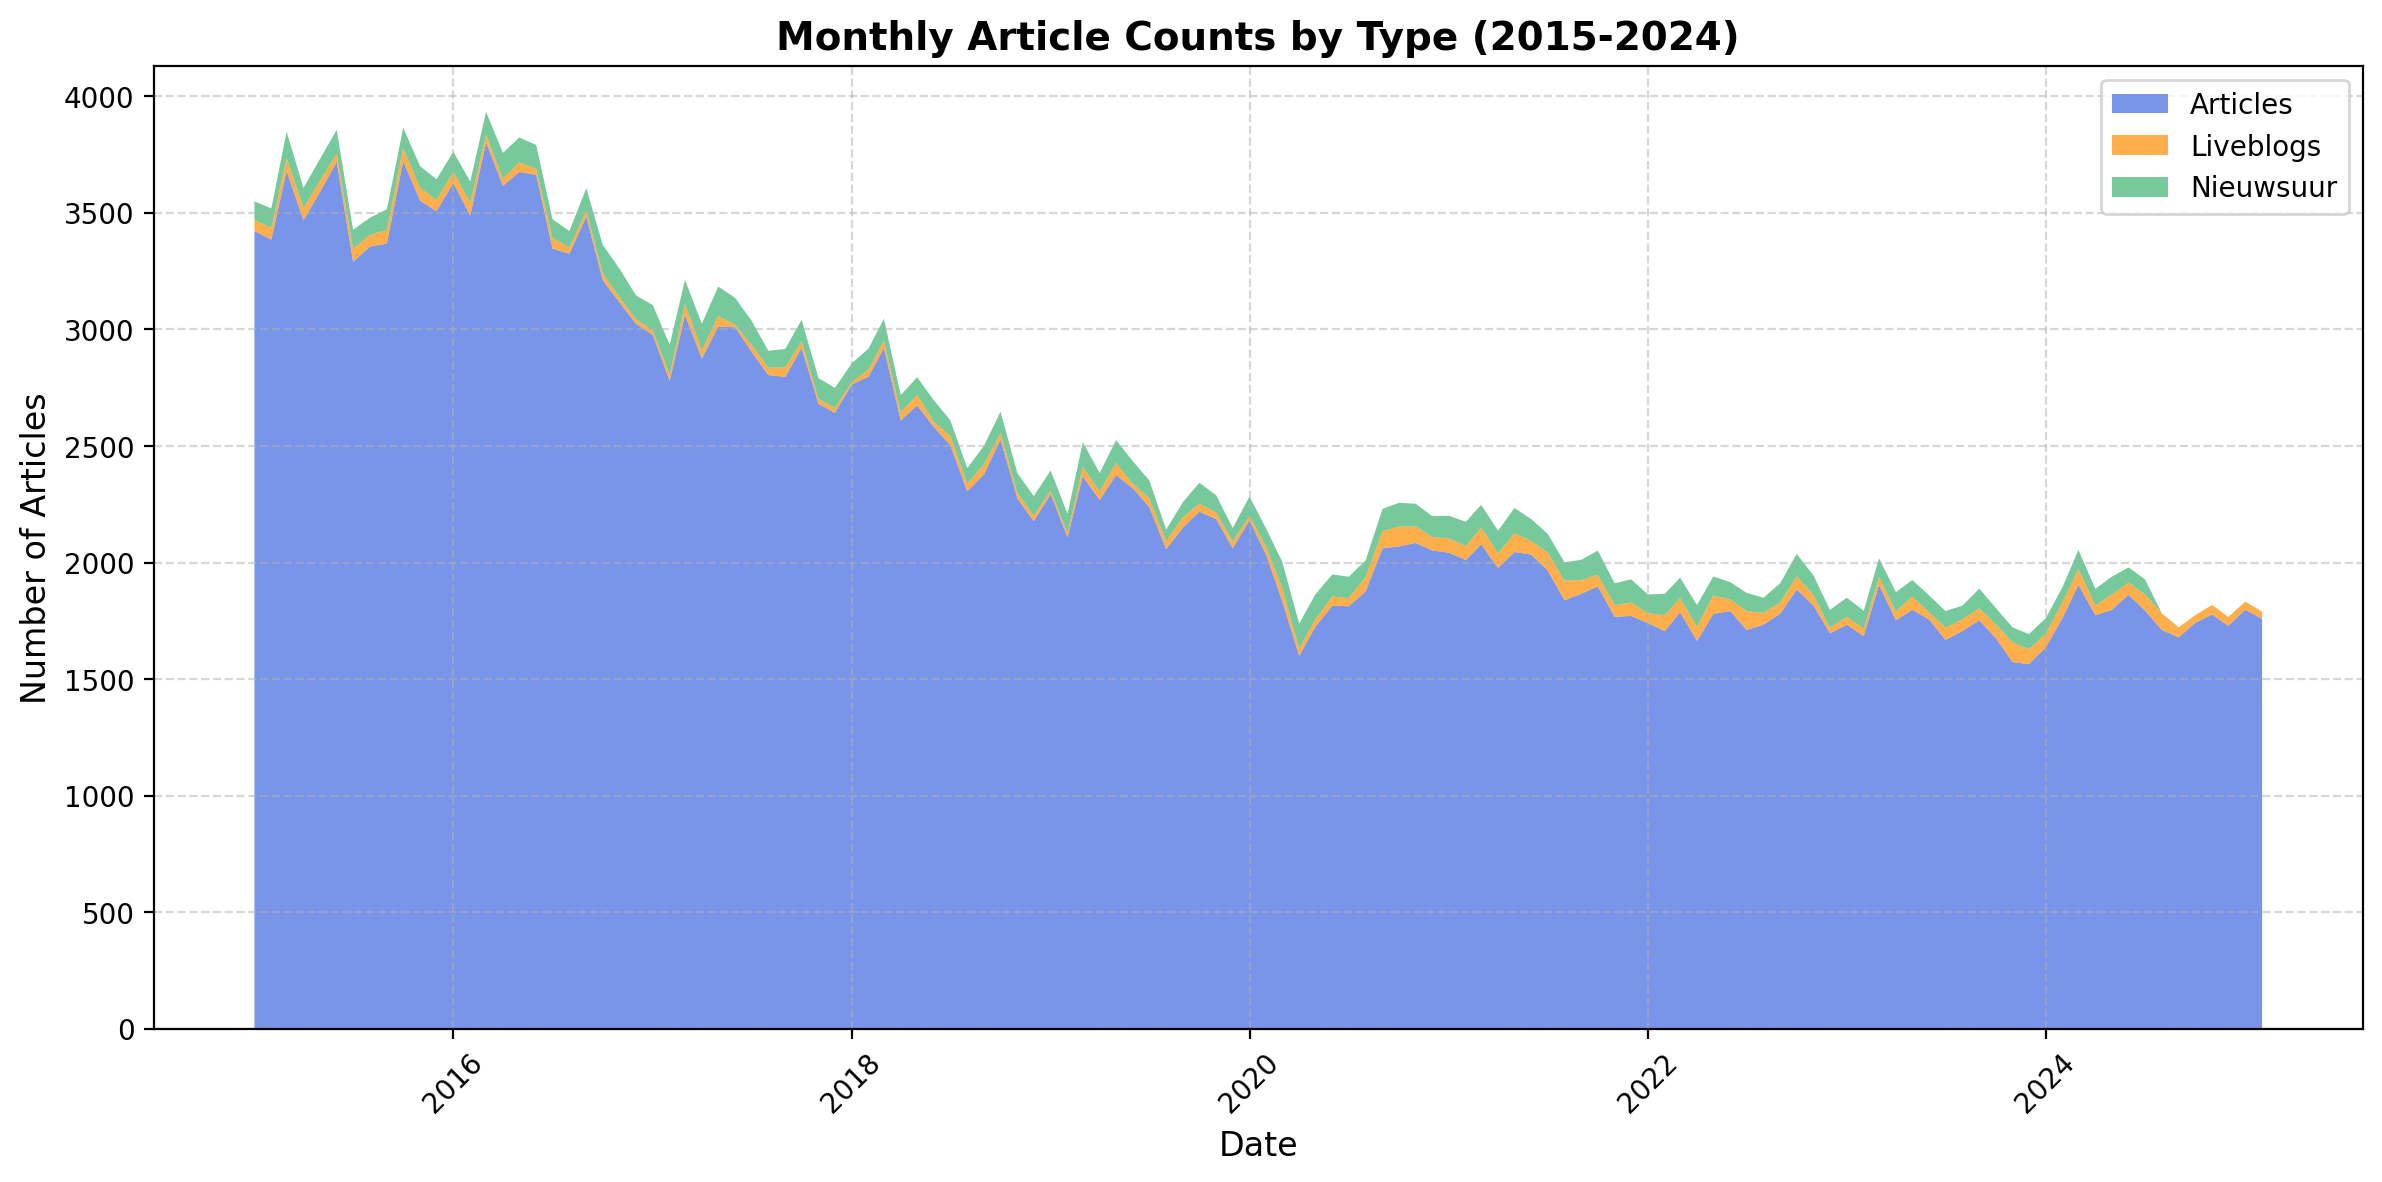

In [22]:

# Extract the year and month
df['year_month'] = df['published_time'].dt.to_period('M')

# Count the number of articles per type
article_counts = df[df['type'] == 'article'].groupby('year_month').size()
liveblog_counts = df[df['type'] == 'liveblog'].groupby('year_month').size()
nieuwsuur_counts = df[df['channel'] == 'nieuwsuur'].groupby('year_month').size()

# Convert to DataFrame for plotting
article_counts_df = article_counts.reset_index(name='article_count')
liveblog_counts_df = liveblog_counts.reset_index(name='liveblog_count')
nieuwsuur_counts_df = nieuwsuur_counts.reset_index(name='nieuwsuur_count')

# Merge the dataframes on 'year_month'
merged_df = article_counts_df.merge(liveblog_counts_df, on='year_month', how='outer').fillna(0)
merged_df = merged_df.merge(nieuwsuur_counts_df, on='year_month', how='outer').fillna(0)

# Convert periods to timestamps for plotting
merged_df['year_month'] = merged_df['year_month'].dt.to_timestamp()

# Plot the stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(merged_df['year_month'], 
              merged_df['article_count'], 
              merged_df['liveblog_count'], 
              merged_df['nieuwsuur_count'], 
              labels=['Articles', 'Liveblogs', 'Nieuwsuur'], 
              colors=['royalblue', 'darkorange', 'mediumseagreen'], 
              alpha=0.7)

# Labels and title
plt.title("Monthly Article Counts by Type (2015-2024)", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [4]:

# Extract the year from the published_time
df['year'] = df['published_time'].dt.year

# Count total occurrences for each type
total_articles = df[df['type'] == 'article'].shape[0]
total_liveblogs = df[df['type'] == 'liveblog'].shape[0]
total_nieuwsuur = df[df['channel'] == 'nieuwsuur'].shape[0]

# Calculate the number of years in the dataset
start_year = df['year'].min()
end_year = df['year'].max()
num_years = end_year - start_year + 1

# Calculate average per year for each type
avg_articles_per_year = total_articles / num_years
avg_liveblogs_per_year = total_liveblogs / num_years
avg_nieuwsuur_per_year = total_nieuwsuur / num_years

# Find the year with the maximum count for each type
articles_per_year = df[df['type'] == 'article'].groupby('year').size()
liveblogs_per_year = df[df['type'] == 'liveblog'].groupby('year').size()
nieuwsuur_per_year = df[df['channel'] == 'nieuwsuur'].groupby('year').size()

max_articles_year = articles_per_year.idxmax()
max_liveblogs_year = liveblogs_per_year.idxmax()
max_nieuwsuur_year = nieuwsuur_per_year.idxmax()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Type': ['Articles', 'Liveblogs', 'Nieuwsuur'],
    'Total Count': [total_articles, total_liveblogs, total_nieuwsuur],
    'Average per Year': [avg_articles_per_year, avg_liveblogs_per_year, avg_nieuwsuur_per_year],
    'Max Year': [max_articles_year, max_liveblogs_year, max_nieuwsuur_year]
})

# Display the table
summary_df


,Type,Total Count,Average per Year,Max Year
0,Articles,287852,26168.363636,2015
1,Liveblogs,5474,497.636364,2021
2,Nieuwsuur,10049,913.545455,2017


### Filteren op EVs

In [26]:
# Define search words
search_words = ["elektrische auto", " EV ", "EVs ", "elektrisch rijden", "laadpaal", "batterij auto", "Tesla", "e-auto", "opladen", "elektrische-automarkt"]

# Apply the filter across multiple columns
mask = df[['title', 'keywords', 'section', 'description', 'content']].apply(
    lambda x: x.str.contains('|'.join(search_words), case=False, na=False)
).any(axis=1)

df_filtered = df[mask]


In [27]:
# Extract year
df_filtered['year'] = df_filtered['published_time'].dt.year

# Count occurrences of each type per year
type_counts = df_filtered.groupby(['year', 'type']).size().unstack(fill_value=0)

# Count occurrences of 'nieuwsuur' as a channel separately
nieuwsuur_counts = df_filtered[df_filtered['channel'] == 'nieuwsuur'].groupby('year').size()

# Ensure 'nieuwsuur' column exists in type_counts DataFrame
type_counts['nieuwsuur'] = nieuwsuur_counts

# Fill missing values with zero if necessary
type_counts = type_counts.fillna(0)

# Calculate total articles per year (sum of all three categories)
type_counts['total'] = type_counts[['article', 'liveblog', 'nieuwsuur']].sum(axis=1)

# Calculate the average number of articles per year
average_articles_per_year = type_counts['total'].mean()


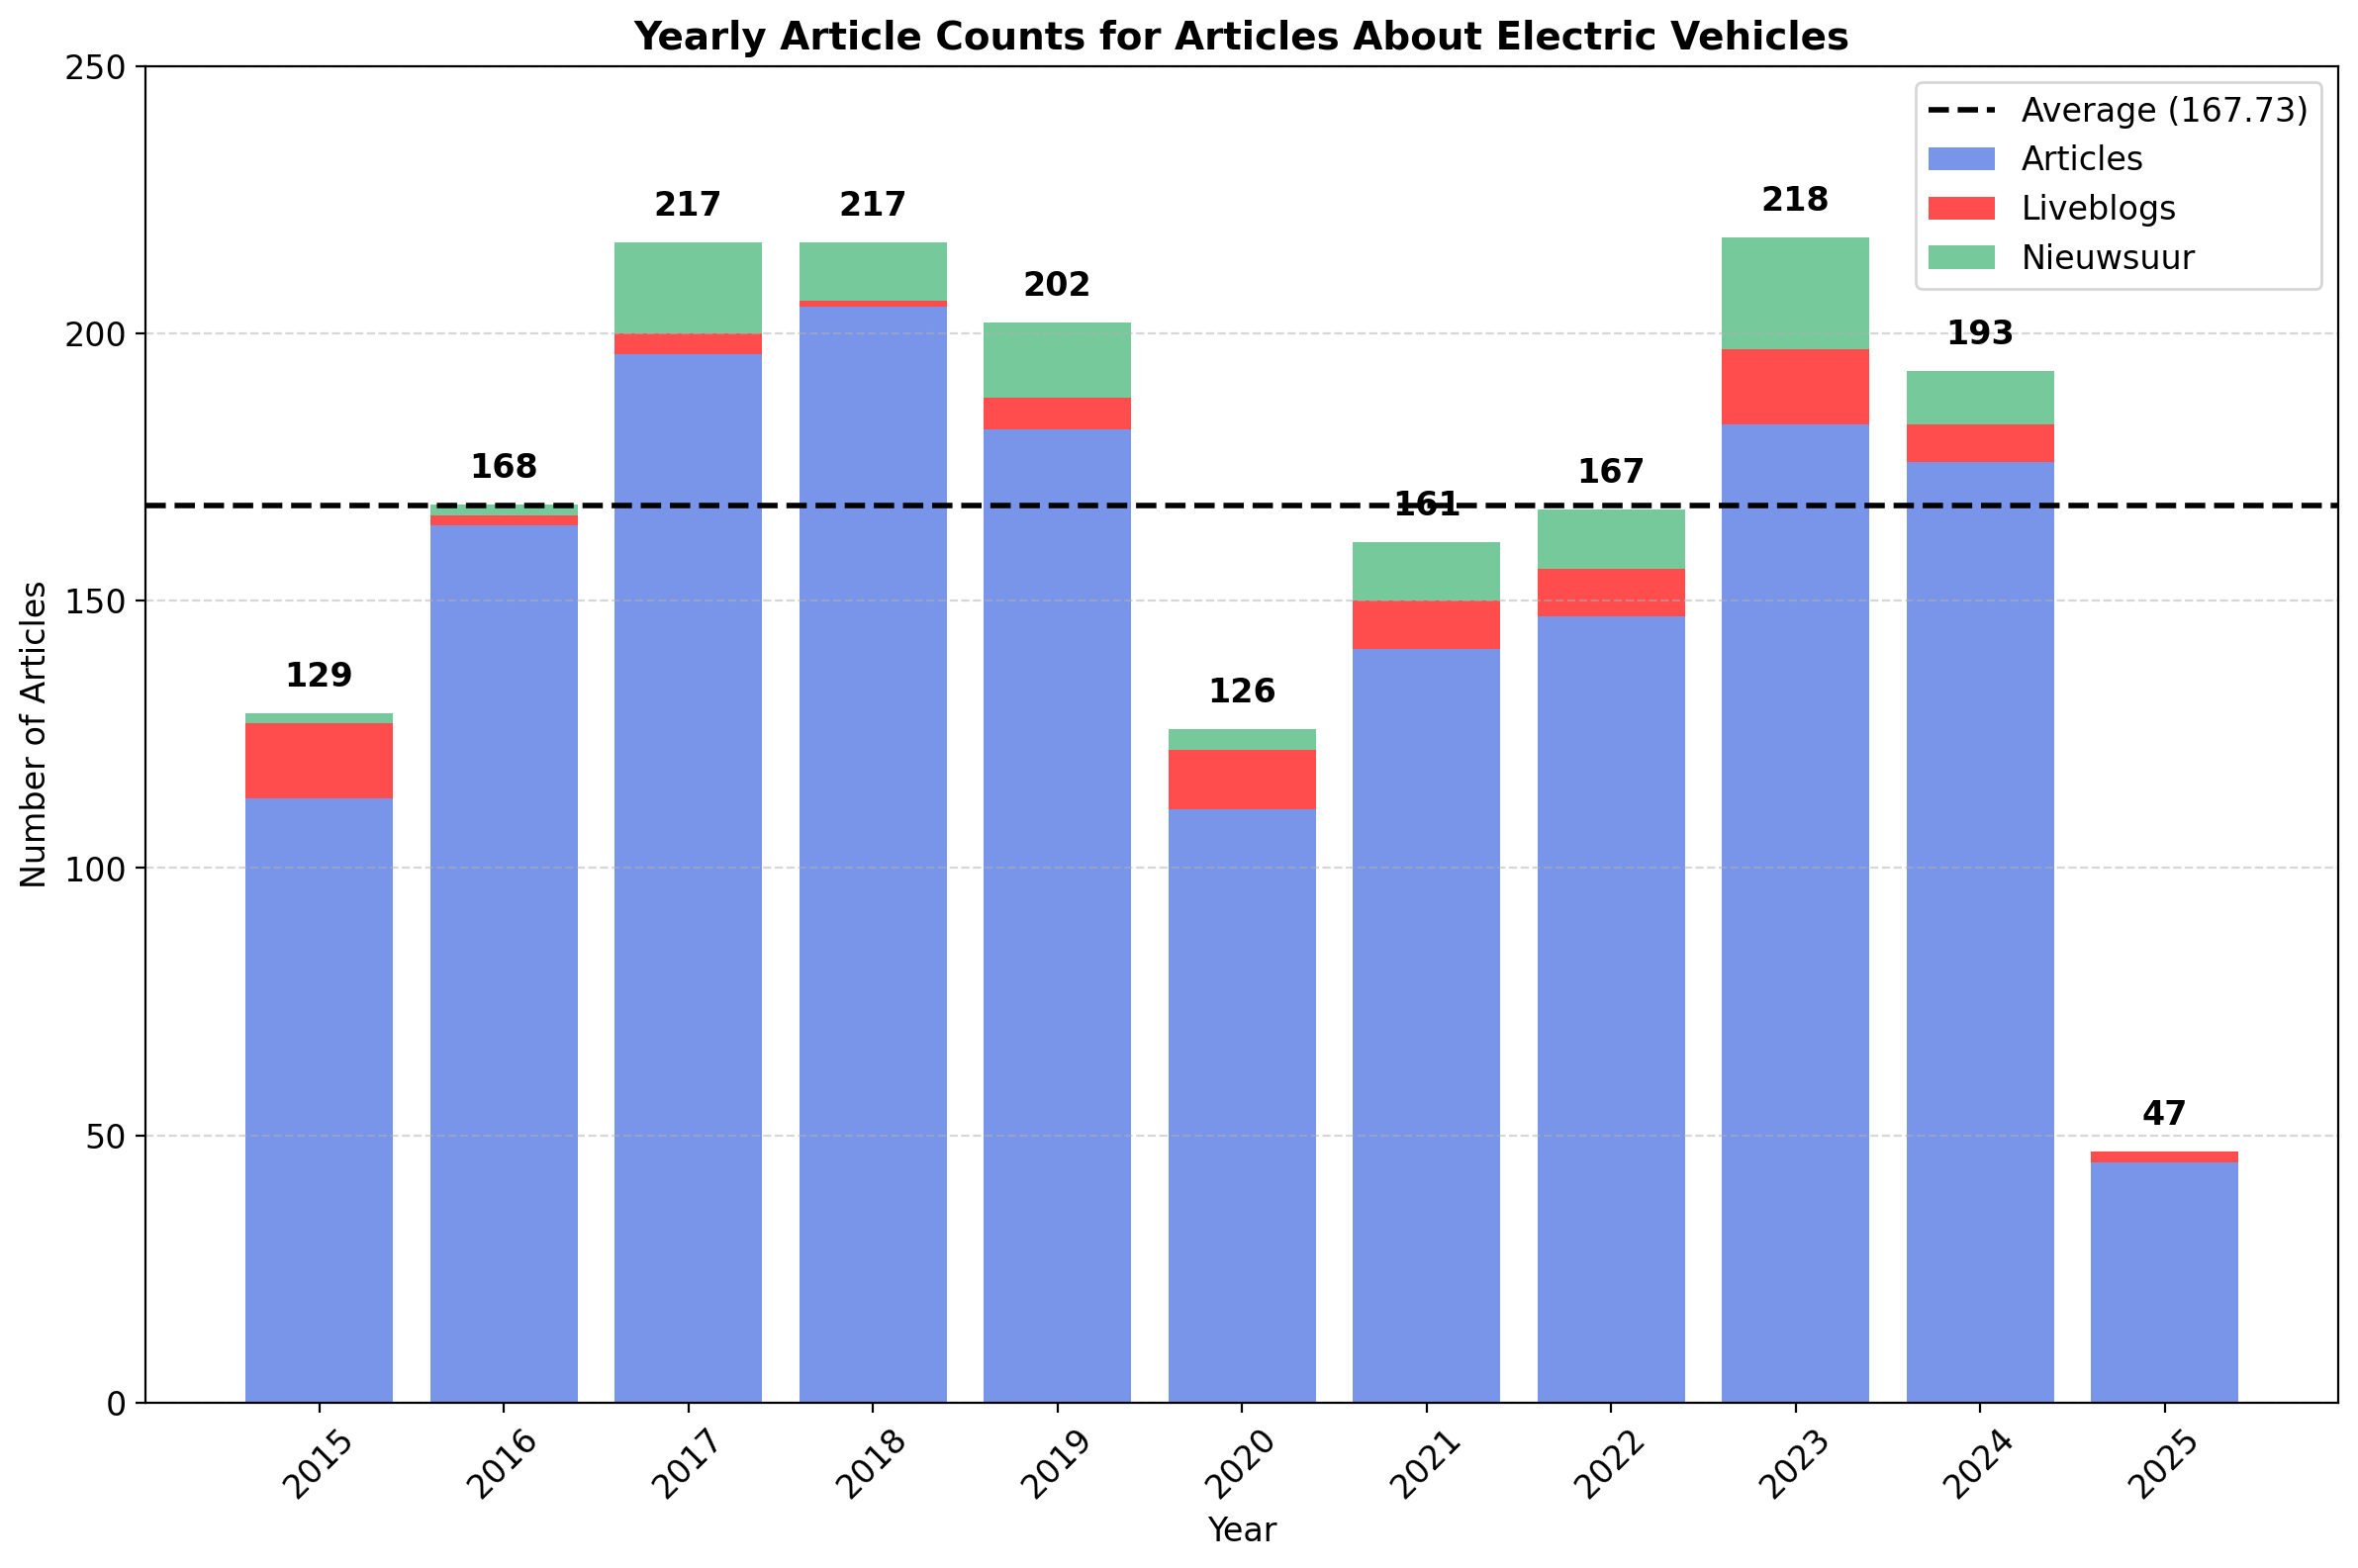

Total number of articles about electric vehicles: 1845.0


In [29]:
import matplotlib.pyplot as plt

# Plot stacked bar chart with increased y-axis limit
plt.figure(figsize=(12, 8))
bars_article = plt.bar(type_counts.index, type_counts['article'], color='royalblue', label="Articles", alpha=0.7)
bars_liveblog = plt.bar(type_counts.index, type_counts['liveblog'], bottom=type_counts['article'], color='red', label="Liveblogs", alpha=0.7)
bars_nieuwsuur = plt.bar(type_counts.index, type_counts['nieuwsuur'], bottom=type_counts['article'] + type_counts['liveblog'], color='mediumseagreen', label="Nieuwsuur", alpha=0.7)

# Add text labels for total count on top of each bar
for i, total in enumerate(type_counts['total']):
    plt.text(type_counts.index[i], total + 5, int(total), ha='center', fontsize=12, fontweight='bold')

# Add average line
plt.axhline(y=average_articles_per_year, color='black', linestyle='dashed', linewidth=2, label=f'Average ({average_articles_per_year:.2f})')

# Labels and title
plt.title("Yearly Article Counts for Articles About Electric Vehicles", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(type_counts.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.ylim(0, 250)  # Set y-axis limit to 250
plt.tight_layout()

# Show the plot
plt.show()
total_ev_articles = type_counts['total'].sum()

# Print the total count
print(f"Total number of articles about electric vehicles: {total_ev_articles}")

#### Aantal artikelen over EVs inlezen 

In [31]:
# Select 5 random articles from the filtered dataset
sample_articles = df_filtered.sample(n=10, random_state=42)[['channel', 'url', 'type', 'title', 'keywords', 'section', 'description', 'published_time']]

# Display the table
print(sample_articles)


       channel                                                url     type  \
118346     nos  https://nos.nl/artikel/2205251-een-onbemande-w...  article   
268972     nos  https://nos.nl/artikel/2501813-nobelprijswinna...  article   
190495     nos  https://nos.nl/artikel/2339289-pot-voor-subsid...  article   
202394     nos  https://nos.nl/collectie/13852/artikel/2362045...  article   
152984     nos  https://nos.nl/artikel/2267599-volkswagen-en-f...  article   
83840      nos  https://nos.nl/artikel/2146892-meer-geld-voor-...  article   
111058     nos  https://nos.nl/artikel/2192724-nederlandse-ene...  article   
248398     nos  https://nos.nl/artikel/2458046-jubelton-helmpl...  article   
224098     nos  https://nos.nl/artikel/2405920-twijfel-bij-ame...  article   
142798     nos  https://nos.nl/artikel/2248998-teleurgestelde-...  article   

                                                    title  \
118346  Een onbemande watertaxi: het kan al wel, maar ...   
268972  Nobelprijsw

# Sentiment Analyse
https://huggingface.co/pdelobelle/robbert-v2-dutch-base


In [44]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline

# Load pre-trained Dutch RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base")

# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Drop rows with missing descriptions
df_filtered = df_filtered.dropna(subset=['description'])

# Apply sentiment analysis to the entire dataset
sentiment_results = sentiment_pipeline(df_filtered['description'].tolist())

# Add sentiment results to df_filtered
df_filtered['sentiment'] = [res['label'] for res in sentiment_results]
df_filtered['sentiment_score'] = [res['score'] for res in sentiment_results]

# Display the first few rows with sentiment analysis results
print(df_filtered[['title', 'description', 'sentiment', 'sentiment_score']].head())


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                                  title  \
1823   Verkoop nieuwe auto's stevent af op laagterecord   
1890                                    De stroom 02/01   
2102     Proces 'Boston-marathon' start met kiezen jury   
2541  Hoe redt 'meesteroplichter' Francisco zich hie...   
2918  Wetenschappers waarschuwen voor kunstmatige in...   

                                            description sentiment  \
1823  Nederlanders kochten in 2014 opnieuw minder au...   LABEL_1   
1890                             De stroom van NOS op 3   LABEL_1   
2102  Een van de twee daders die levend werd gepakt,...   LABEL_1   
2541  Vandaag staat een 20-jarige Spaanse student vo...   LABEL_1   
2918         Een terechte waarschuwing, of overdreven?    LABEL_1   

      sentiment_score  
1823         0.515548  
1890         0.533665  
2102         0.546471  
2541         0.554917  
2918         0.588822  


In [47]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline

# Load the tokenizer and model
model_name = "DTAI-KULeuven/robbert-v2-dutch-sentiment"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Drop rows with missing descriptions
df_filtered = df_filtered.dropna(subset=['description'])

# Apply sentiment analysis to the dataset
sentiment_results = sentiment_pipeline(df_filtered['description'].tolist())

# Add sentiment results to df_filtered
df_filtered['sentiment'] = [res['label'] for res in sentiment_results]
df_filtered['sentiment_score'] = [res['score'] for res in sentiment_results]

# Display the first few rows with sentiment analysis results
print(df_filtered[['title', 'description', 'sentiment', 'sentiment_score']].head())


tokenizer_config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/733k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/383k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/875 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

                                                  title  \
1823   Verkoop nieuwe auto's stevent af op laagterecord   
1890                                    De stroom 02/01   
2102     Proces 'Boston-marathon' start met kiezen jury   
2541  Hoe redt 'meesteroplichter' Francisco zich hie...   
2918  Wetenschappers waarschuwen voor kunstmatige in...   

                                            description sentiment  \
1823  Nederlanders kochten in 2014 opnieuw minder au...  Positive   
1890                             De stroom van NOS op 3  Positive   
2102  Een van de twee daders die levend werd gepakt,...  Positive   
2541  Vandaag staat een 20-jarige Spaanse student vo...  Negative   
2918         Een terechte waarschuwing, of overdreven?   Negative   

      sentiment_score  
1823         0.998817  
1890         0.993424  
2102         0.550519  
2541         0.889621  
2918         0.999275  


<Figure size 1200x600 with 0 Axes>

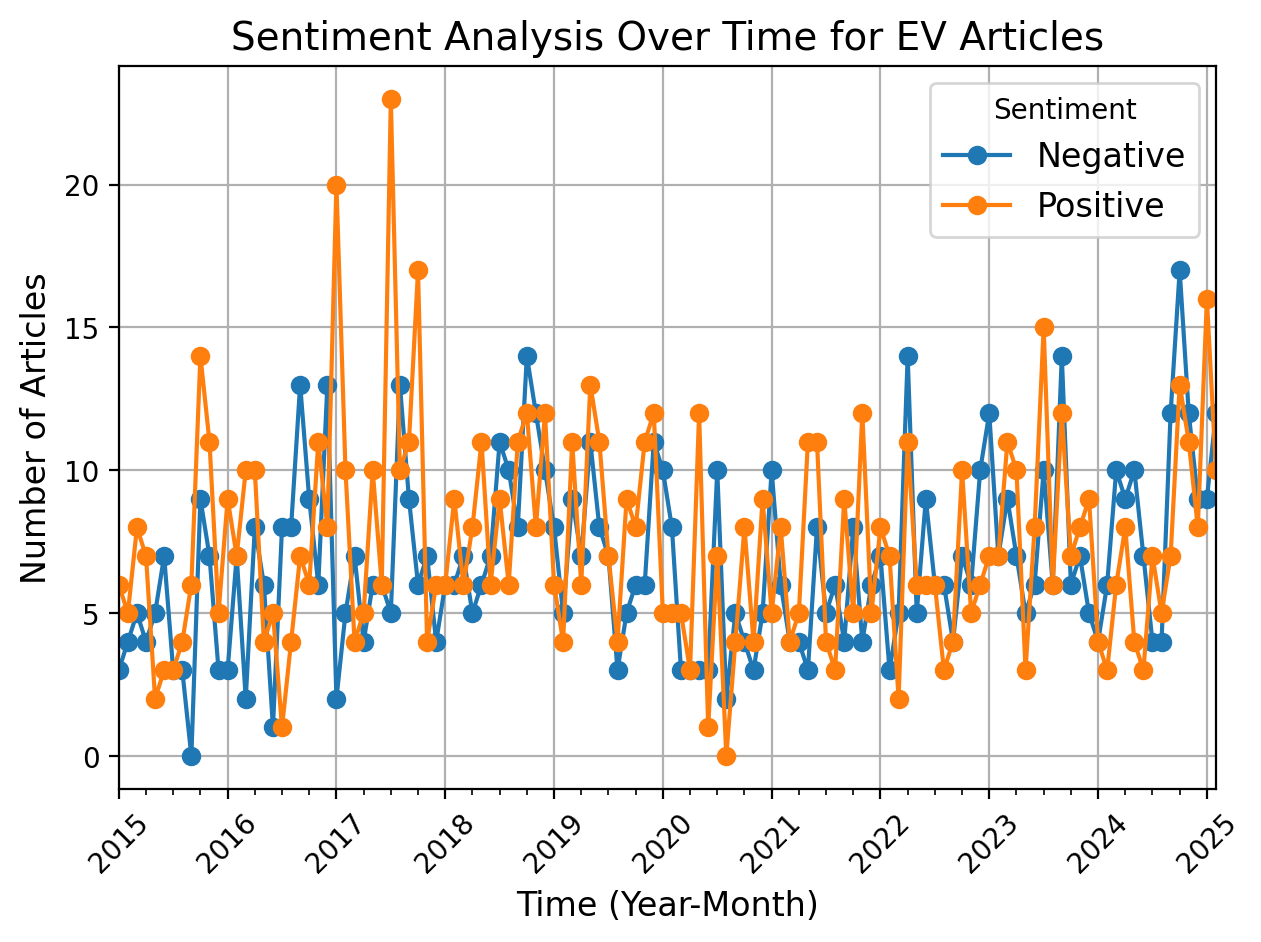

In [48]:
df_filtered['published_time'] = pd.to_datetime(df_filtered['published_time'])

df_filtered['year_month'] = df_filtered['published_time'].dt.to_period('M')
sentiment_counts = df_filtered.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)

sentiment_counts = df_filtered.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)




plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='line', marker='o')

plt.title('Sentiment Analysis Over Time for EV Articles', fontsize=14)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.legend(title='Sentiment', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [42]:
from transformers import RobertaConfig

# Load model configuration to check label mapping
config = RobertaConfig.from_pretrained("pdelobelle/robbert-v2-dutch-base")
print(config.id2label)



{0: 'LABEL_0', 1: 'LABEL_1'}
